In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math

print(yf.__version__)

0.2.58


In [13]:
symbol = '^GSPC'
#symbols = ['^IXIC']
ohlcv = yf.download(symbol, start="2019-01-01", end="2025-12-06", group_by="Ticker")
ohlcv = ohlcv[symbol]
ohlcv

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,3733160000
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,3858830000
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,4234140000
2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,4133120000
2019-01-08,2568.110107,2579.820068,2547.560059,2574.409912,4120060000
...,...,...,...,...,...
2025-12-01,6812.299805,6843.649902,6799.939941,6812.629883,4549370000
2025-12-02,6830.959961,6851.549805,6806.709961,6829.370117,4582290000
2025-12-03,6815.290039,6862.419922,6810.430176,6849.720215,4736780000


In [14]:
def calc_highpass(price, period):
    
    a1 = np.exp(-1.414 * np.pi / period)
    b1 = 2 * a1 * np.cos(math.radians(1.414 * 180 / period))
    c2 = b1
    c3 = -a1 * a1
    c1 = (1 + c2 - c3)/4

    out_values = []
    for i in range(len(price)):
        if i >= 4:
            out_values.append(
                c1*(price[i] - 2*price[i-1] + price[i-2]) + c2*out_values[i-1] + c3*out_values[i-2]
            )
        else:
            out_values.append(price[i])
    
    return out_values


def calc_rms(price):

    length = len(price)
    sum_sq = 0
    for count in range(length):
        sum_sq += price[count] * price[count]
    return np.sqrt(sum_sq / length)
    

def calc_ultimate_oscillator(close, band_edge, band_width):

    df = close.to_frame('Close')
    df['HP1'] = calc_highpass(df['Close'], band_width * band_edge)
    df['HP2'] = calc_highpass(df['Close'], band_edge)
    df['Signal'] = df['HP1'] - df['HP2']
    df['RMS'] = df['Signal'].rolling(100).apply(calc_rms)
    df['UO'] = df['Signal']/df['RMS']
    
    return df['UO']


def calc_ema(values, period):

    aa = 3/period
    aa = 2 / (period + 1)
    
    ema = []
    for i in range(len(values)):
        if i != 0:
            ema.append(aa*values[i] + (1-aa)*ema[i-1]) 
        else:
            ema.append(values[i]) 
            
    return ema


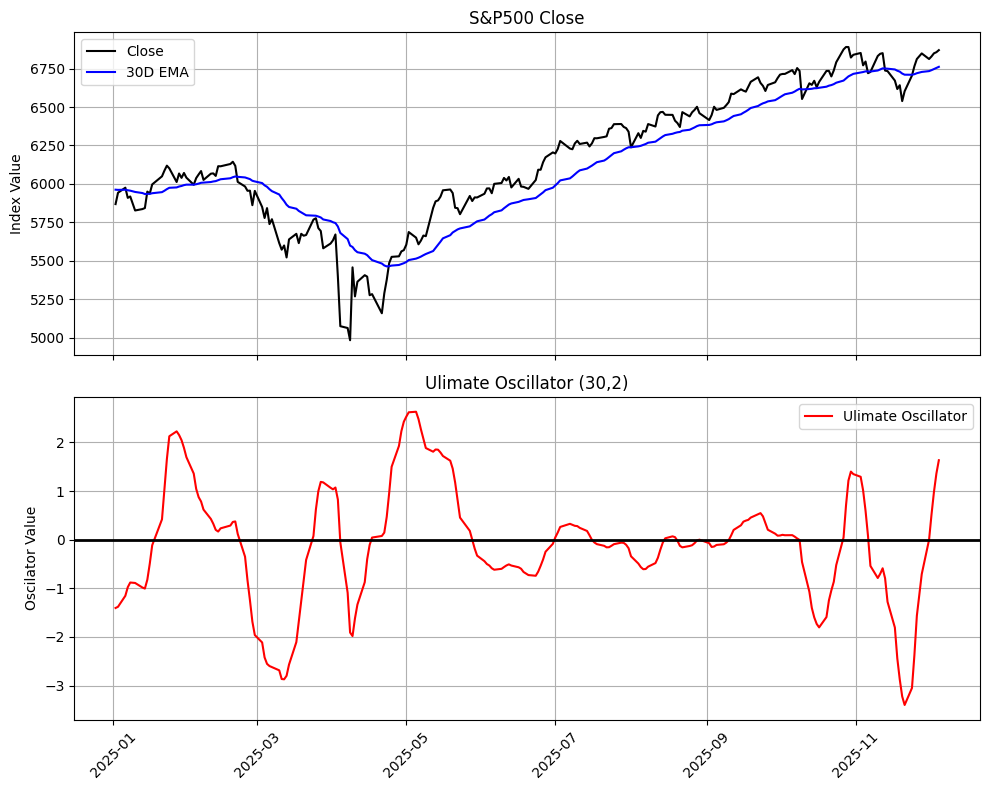

In [15]:
def plot_uo(df):

    # Create a figure with two subplots stacked vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Plotting the first subplot (e.g., Price Data)
    ax1.plot(df.index, df['Close'], label='Close', color='black')

    if 'EMA' in list(df):
        ax1.plot(df.index, df['EMA'], label=f'{length}D EMA', color='blue')
    if 'SS' in list(df):
        ax1.plot(df.index, df['SS'], label='SuperSmoother', color='blue')
        
    if 'US' in list(df):
        ax1.plot(df.index, df['US'], label='UltimateSmoother', color='blue')

    ax1.set_title('S&P500 Close')
    ax1.set_ylabel('Index Value')
    ax1.legend()
    ax1.grid(True)
    
    # Plotting the second subplot (e.g., Another Data Series)
    ax2.plot(df.index, df['UO'], label=f'Ulimate Oscillator', color='red')
    ax2.axhline(0, color='black',linewidth=2)
    ax2.set_title(f'Ulimate Oscillator ({band_edge},{band_width})')
    ax2.legend()
    ax2.set_xlabel('')
    ax2.set_ylabel('Oscilator Value')
    ax2.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Automatically adjust the layout to prevent overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()



band_edge=30
band_width=2
length = band_edge

df = ohlcv.copy()
df['EMA'] = calc_ema(df['Close'], period=length)
df['UO'] = calc_ultimate_oscillator(df['Close'], band_edge, band_width)
plot_uo(df['2025':'2025'])